# Sentiment Analysis Exercise  

The goal of the Sentiment Analysis (SA) task is to classify the sentiment within a piece of text. This sentiment can be either binary (positive-negative) or multi-class (a rating scale from 1 to 5).
 
Data: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz
 
Steps to Solve This Exercise
1. Load data into a pandas DataFrame
2. Preprocessing & Vectorizing 
3. Building Model
4. Evaluation

Note: Submit only a single Jupyter Notebook file that can handle all tasks, including data downloading, preprocessing, and model training. (Submissions that do not follow the guidelines will receive a score of 0.)

# Install and Import

In [1]:
%pip install gdown pandas numpy seaborn matplotlib scikit-learn nltk tqdm xgboost joblib wget

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import sys
import os
import platform
import gzip
import re
import joblib
import json
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [3]:
tqdm.pandas(desc="Processing text")

In [4]:
# pd.set_option("max_colwidth", None)

In [5]:
# Python environment details
print("Python executable being used:", sys.executable)
print("Python version:", sys.version)

# Operating System details
print("Operating System:", platform.system())
print("OS Version:", platform.version())
print("OS Release:", platform.release())

# Machine and architecture details
print("Machine:", platform.machine())

# Visual Studio Code details (based on environment variable)
vscode_info = os.environ.get('VSCODE_PID', None)
if vscode_info:
    print("Running in Visual Studio Code")
else:
    print("Not running in Visual Studio Code")

Python executable being used: c:\Python312\python.exe
Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
Operating System: Windows
OS Version: 10.0.19045
OS Release: 10
Machine: AMD64
Running in Visual Studio Code


# Load data

In [6]:
# Download the dataset
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz"
filename = "reviews_Digital_Music_5.json.gz"

# Check if the file already exists
if not os.path.exists(filename):
    print("Downloading dataset...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Dataset downloaded and saved as {filename}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File already exists: {filename}")


File already exists: reviews_Digital_Music_5.json.gz


In [7]:
# Load JSON file
def load_data(file_path):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load the dataset into a DataFrame
df = load_data(filename)

# Display basic info
print("\nDataset Sample:")
print(df.head())


Dataset Sample:
       reviewerID        asin          reviewerName helpful  \
0  A3EBHHCZO6V2A4  5555991584  Amaranth "music fan"  [3, 3]   
1   AZPWAXJG9OJXV  5555991584             bethtexas  [0, 0]   
2  A38IRL0X2T4DPF  5555991584           bob turnley  [2, 2]   
3  A22IK3I6U76GX0  5555991584                 Calle  [1, 1]   
4  A1AISPOIIHTHXX  5555991584           Cloud "..."  [1, 1]   

                                          reviewText  overall  \
0  It's hard to believe "Memory of Trees" came ou...      5.0   
1  A clasically-styled and introverted album, Mem...      5.0   
2  I never thought Enya would reach the sublime h...      5.0   
3  This is the third review of an irish album I w...      5.0   
4  Enya, despite being a successful recording art...      4.0   

                        summary  unixReviewTime   reviewTime  
0       Enya's last great album      1158019200  09 12, 2006  
1      Enya at her most elegant       991526400   06 3, 2001  
2               The best

# Preprocess

In [8]:
df1 = df[['reviewText', 'overall']]
df1.head()

,reviewText,overall
0,"It's hard to believe ""Memory of Trees"" came ou...",5.0
1,"A clasically-styled and introverted album, Mem...",5.0
2,I never thought Enya would reach the sublime h...,5.0
3,This is the third review of an irish album I w...,5.0
4,"Enya, despite being a successful recording art...",4.0


In [9]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64706 non-null  object 
 1   overall     64706 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1011.2+ KB


In [10]:
df1['overall'].unique()

array([5., 4., 3., 1., 2.])

In [11]:
value_counts = df1['overall'].value_counts()
print(value_counts)

overall
5.0    35580
4.0    16536
3.0     6789
2.0     3010
1.0     2791
Name: count, dtype: int64


In [12]:
# Convert ratings to binary sentiment (1-3 = negative, 4-5 = positive)
df1['sentiment'] = df1['overall'].apply(lambda x: 1 if x > 3 else 0)


C:\Users\User\AppData\Local\Temp\ipykernel_15668\3116498781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['sentiment'] = df1['overall'].apply(lambda x: 1 if x > 3 else 0)


In [13]:
value_counts = df1['sentiment'].value_counts()
print(value_counts)

sentiment
1    52116
0    12590
Name: count, dtype: int64


In [14]:
def remove_special_characters(text):
    """
    Remove special characters and punctuation from text.
    """
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r'http\S+|https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'\n|\t|\r|\f|\b', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text.strip()

def lowercase_text(text):
    """
    Convert text to lowercase.
    """
    return text.lower()

def tokenize_text(text):
    """
    Tokenize text into words.
    """
    return word_tokenize(text)

def remove_stopwords(words, language="english"):
    """
    Remove stopwords from a list of words.
    """
    stop_words = set(stopwords.words(language))
    return [word for word in words if word not in stop_words]

def stem_words(words):
    """
    Apply stemming to a list of words.
    Stemming reduces words to their base form using rule-based heuristics.
    """
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """
    Apply lemmatization to a list of words.
    Lemmatization reduces words to their dictionary form using linguistic rules.
    """
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def remove_html_tags(text):
    """ 
    Remove html tags from text
    """
    clean_text = re.sub(r'<.*?>', '', text)
    return clean_text

def remove_mention(text):
    """ 
    Remove @mentions
    """
    # Remove @mentions
    clean_text = re.sub(r'@\w+', '', text)
    return clean_text

def remove_urls(text):
    """ 
    Remove urls from text
    """
    clean_text = re.sub(r'http\S+', '', text)
    return clean_text

def replace_chat_words(text):
    chat_words = {
        "BRB": "Be right back",
        "BTW": "By the way",
        "OMG": "Oh my God/goodness",
        "TTYL": "Talk to you later",
        "OMW": "On my way",
        "SMH/SMDH": "Shaking my head/shaking my darn head",
        "LOL": "Laugh out loud",
        "TBD": "To be determined", 
        "IMHO/IMO": "In my humble opinion",
        "HMU": "Hit me up",
        "IIRC": "If I remember correctly",
        "LMK": "Let me know", 
        "OG": "Original gangsters (used for old friends)",
        "FTW": "For the win", 
        "NVM": "Nevermind",
        "OOTD": "Outfit of the day", 
        "Ngl": "Not gonna lie",
        "Rq": "real quick", 
        "Iykyk": "If you know, you know",
        "Ong": "On god (I swear)", 
        "YAAAS": "Yes!", 
        "Brt": "Be right there",
        "Sm": "So much",
        "Ig": "I guess",
        "Wya": "Where you at",
        "Istg": "I swear to god",
        "Hbu": "How about you",
        "Atm": "At the moment",
        "Asap": "As soon as possible",
        "Fyi": "For your information",
        "Tbh": "To be honest",
        "Wtf": "What the fuck",
        "Idk": "I don't know"
    }
    for word, expanded_form in chat_words.items():
        text = text.replace(word, expanded_form)
    return text

def text_preprocessing(
    text,
    remove_special=True,
    to_lowercase=True,
    remove_stopwords_flag=True,
    stem_flag=False,
    lemmatize_flag=False,
    tokenize_flag=True,
    language="english",
):
    """
    Perform text preprocessing with multiple configurable steps.

    :param text: The input text string to preprocess.
    :param remove_special: Whether to remove special characters.
    :param to_lowercase: Whether to convert the text to lowercase.
    :param remove_stopwords_flag: Whether to remove stopwords from the text.
    :param stem_flag: Whether to apply stemming.
    :param lemmatize_flag: Whether to apply lemmatization.
    :param tokenize_flag: Whether to tokenize the text into words.
    :param language: Language to use for stopwords and tokenization.
    :return: Preprocessed text.
    """
    from nltk.tokenize import sent_tokenize
    
    # Split the text into sentences for better handling of long texts
    sentences = sent_tokenize(text)

    processed_sentences = []
    for sentence in sentences:
        # Step 1: Remove special characters
        sentence = remove_mention(sentence)
        sentence = remove_html_tags(sentence)
        sentence = remove_urls(sentence)
        sentence = replace_chat_words(sentence)
        
        if remove_special:
            sentence = remove_special_characters(sentence)
        
        # Step 2: Convert to lowercase
        if to_lowercase:
            sentence = lowercase_text(sentence)
        
        # Step 3: Tokenize the sentence into words
        words = tokenize_text(sentence)
        
        # Step 4: Remove stopwords
        if remove_stopwords_flag:
            words = remove_stopwords(words, language)
        
        # Step 5: Apply stemming
        if stem_flag:
            words = stem_words(words)
        
        # Step 6: Apply lemmatization
        if lemmatize_flag:
            words = lemmatize_words(words)
        
        # Step 7: Reconstruct the sentence from words
        processed_sentences.append(" ".join(words))

    # Merge sentences back into text
    return " ".join(processed_sentences)



In [15]:
# Example text
text = """
This is an example sentence to demonstrate text preprocessing!
It includes punctuation, CAPITALIZED words, and stopwords.
"""

processed_text = text_preprocessing(
    text,
    remove_special=True,
    to_lowercase=True,
    remove_stopwords_flag=False,
    stem_flag=False,
    lemmatize_flag=True,
)

print("Original Text:\n", text)
print("Processed Text:\n", processed_text)

Original Text:
 
This is an example sentence to demonstrate text preprocessing!
It includes punctuation, CAPITALIZED words, and stopwords.

Processed Text:
 this is an example sentence to demonstrate text preprocessing it includes punctuation capitalized word and stopwords


In [16]:
# # Convert ratings to binary sentiment (1-3 = negative, 4-5 = positive)
# df1.head()

In [17]:
# df1.info()

In [18]:
# # Rename 'text' to 'reviewText' safely
# df1 = df1.rename(columns={"text": "reviewText"})

# # Check if 'reviewText' column exists after renaming
# if "reviewText" not in df1.columns:
#     raise KeyError("Column 'text' was not found in the DataFrame.")

# # Apply text preprocessing
# df1['text_clean'] = df1['reviewText'].astype(str).progress_apply(lambda x: text_preprocessing(
#     text=x,
#     remove_special=True,
#     to_lowercase=True,
#     remove_stopwords_flag=False,
#     tokenize_flag=True,
#     stem_flag=False,
#     lemmatize_flag=True
# ))

In [19]:
df1.head()

,reviewText,overall,sentiment
0,"It's hard to believe ""Memory of Trees"" came ou...",5.0,1
1,"A clasically-styled and introverted album, Mem...",5.0,1
2,I never thought Enya would reach the sublime h...,5.0,1
3,This is the third review of an irish album I w...,5.0,1
4,"Enya, despite being a successful recording art...",4.0,1


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64706 non-null  object 
 1   overall     64706 non-null  float64
 2   sentiment   64706 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


# Vectorizer

In [21]:
# # Adjust overall ratings to start from 0
# df1['overall'] = df1['overall'] - 1  # Shifts [1,2,3,4,5] -> [0,1,2,3,4]


In [22]:
# df1.head()

In [23]:
# # Save DataFrame to CSV
# csv_save_path = "df1.csv"
# df1.to_csv(csv_save_path, index=False)

# print(f"✅ Results saved to {csv_save_path}")

In [24]:
df1 = pd.read_csv("df1.csv")
df1.head()

,reviewText,overall,sentiment,text_clean
0,"It's hard to believe ""Memory of Trees"" came ou...",4.0,1,it hard to believe memory of tree came out yea...
1,"A clasically-styled and introverted album, Mem...",4.0,1,a clasicallystyled and introverted album memor...
2,I never thought Enya would reach the sublime h...,4.0,1,i never thought enya would reach the sublime h...
3,This is the third review of an irish album I w...,4.0,1,this is the third review of an irish album i w...
4,"Enya, despite being a successful recording art...",3.0,1,enya despite being a successful recording arti...


In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64705 non-null  object 
 1   overall     64706 non-null  float64
 2   sentiment   64706 non-null  int64  
 3   text_clean  64705 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.0+ MB


In [26]:
df_cleaned = df1.dropna(subset=['reviewText'])
print(df_cleaned.info())
df1 = df_cleaned

<class 'pandas.core.frame.DataFrame'>
Index: 64705 entries, 0 to 64705
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64705 non-null  object 
 1   overall     64705 non-null  float64
 2   sentiment   64705 non-null  int64  
 3   text_clean  64705 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.5+ MB
None


In [29]:
# Transform text data using TF-IDF
vectorizer_sentiment = TfidfVectorizer(max_features=10000)
X_sentiment_tfidf = vectorizer_sentiment.fit_transform(df_cleaned['text_clean'])

# Split data for `sentiment` prediction
X_train_sentiment_tfidf, X_test_sentiment_tfidf, y_train_sentiment, y_test_sentiment = train_test_split(
    X_sentiment_tfidf, df1['sentiment'], test_size=0.2, random_state=42
)


In [30]:
print(X_train_sentiment_tfidf.shape)
print(X_test_sentiment_tfidf.shape)

(51764, 10000)
(12941, 10000)


# Build Model

I have read here on the link and get the information about models used for multiclass classification and then i try to run all of them

https://scikit-learn.org/stable/modules/multiclass.html

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
from scipy.sparse import issparse
from xgboost import XGBClassifier

# Define models for sentiment classification
models_sentiment = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="saga", tol=1e-3, random_state=42),
    "BernoulliNB": BernoulliNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=10, random_state=42),
    "ExtraTreeClassifier": ExtraTreeClassifier(max_depth=10, random_state=42),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42),
    "GaussianNB": GaussianNB(var_smoothing=1e-9),
    "LinearSVC": LinearSVC(multi_class="crammer_singer", max_iter=2000, tol=1e-3, dual=False, random_state=42),
    "NearestCentroid": NearestCentroid(),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, learning_rate_init=0.01, early_stopping=True, random_state=42)
    # "RidgeClassifierCV": RidgeClassifierCV(), - ok but 5mins / fold
    # "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5, leaf_size=30),
    # "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(tol=1e-3, reg_param=0.1), # so long
    # "NearestCentroid": NearestCentroid(),
    # "RandomForestClassifier": RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42),
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate models using K-Fold Cross-Validation
results_sentiment = {}
best_model_sentiment = None
best_accuracy = 0

trained_models_sentiment = {}  # Store trained models

for model_name, model in models_sentiment.items():
    print(f"Training and evaluating {model_name}...")

    # K-Fold Cross-Validation
    accuracy_scores, roc_auc_scores, f1_scores = [], [], []
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in tqdm(k_fold.split(X_train_sentiment_tfidf), total=k_fold.get_n_splits(), desc="K-Fold Progress"):
        X_train, X_val = X_train_sentiment_tfidf[train_index], X_train_sentiment_tfidf[val_index]
        y_train, y_val = y_train_sentiment.iloc[train_index], y_train_sentiment.iloc[val_index]

        # Convert to dense format for models that require it
        if isinstance(model, (GaussianNB, MLPClassifier, NearestCentroid)):
            if issparse(X_train):  # Check if it's sparse
                X_train = X_train.toarray()
                X_val = X_val.toarray()

        # Scale data for distance-based models
        if isinstance(model, (RadiusNeighborsClassifier, KNeighborsClassifier)):
            scaler = StandardScaler(with_mean=False)  # Handle sparse matrix
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
 
        accuracy_scores.append(accuracy_score(y_val, val_preds))

        if hasattr(model, "predict_proba"):  
            val_probs = model.predict_proba(X_val)
            # Check probability sum validity before calculating ROC AUC
            if not np.allclose(1, val_probs.sum(axis=1)):
                print(f"⚠️ Skipping ROC AUC for {model_name} due to invalid probabilities.")
                roc_auc = None
            else:
                # roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')
                
                if val_probs.ndim > 1:
                    val_probs = val_probs.argmax(axis=1)

                # Compute ROC AUC score
                roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr', average='weighted')

        else:
            roc_auc = None  

        f1_scores.append(f1_score(y_val, val_preds, average='weighted'))
        if roc_auc is not None:
            roc_auc_scores.append(roc_auc)

    # Compute average scores
    avg_acc = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    avg_roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else None

    # Store trained model
    trained_models_sentiment[model_name] = model  # ✅ Save trained model
    results_sentiment[model_name] = {
        "Accuracy": avg_acc,
        "F1 Score": avg_f1,
        "ROC AUC": avg_roc_auc,
        "Accuracy Scores": accuracy_scores,
        "F1 Scores": f1_scores,
        "ROC AUC Scores": roc_auc_scores
    }

    # Update Best Model
    if avg_acc > best_accuracy:
        best_accuracy = avg_acc
        best_model_sentiment = model_name

print(f"\n🏆 Best Model: {best_model_sentiment} with Accuracy: {best_accuracy:.3f}")

Training and evaluating LogisticRegression...


K-Fold Progress: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Training and evaluating BernoulliNB...


K-Fold Progress: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Training and evaluating DecisionTreeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [02:15<00:00, 27.07s/it]


Training and evaluating ExtraTreeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Training and evaluating ExtraTreesClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:47<00:00,  9.55s/it]


Training and evaluating GaussianNB...


K-Fold Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Training and evaluating LogisticRegression...

K-Fold Progress:   0%|          | 0/5 [00:00<?, ?it/s]K-Fold Progress: 100%|██████████| 5/5 [00:54<00:00, 10.88s/it]

Training and evaluating BernoulliNB...

K-Fold Progress: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

Training and evaluating DecisionTreeClassifier...

K-Fold Progress: 100%|██████████| 5/5 [08:41<00:00, 104.33s/it]

Training and evaluating ExtraTreesClassifier...

K-Fold Progress: 100%|██████████| 5/5 [04:33<00:00, 54.62s/it]

Training and evaluating GaussianNB...

K-Fold Progress: 100%|██████████| 5/5 [06:05<00:00, 73.18s/it] 

Training and evaluating KNeighborsClassifier...

K-Fold Progress: 100%|██████████| 5/5 [45:57<00:00, 551.41s/it]

Training and evaluating LinearSVC...

K-Fold Progress:  40%|████      | 2/5 [00:13<00:20,  6.90s/it]c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(

K-Fold Progress: 100%|██████████| 5/5 [00:51<00:00, 10.23s/it]

Training and evaluating MLPClassifier...

K-Fold Progress: 100%|██████████| 5/5 [11:09<00:00, 133.87s/it]

Training and evaluating NearestCentroid...

K-Fold Progress: 100%|██████████| 5/5 [00:47<00:00,  9.43s/it]

🏆 Best Model: LinearSVC with Accuracy: 0.877



# Evaluate the model

Result of Training and evaluating LogisticRegression...
📊 LogisticRegression - Average Accuracy: 0.874
📊 LogisticRegression - Average F1 Score: 0.861
📊 LogisticRegression - Average ROC AUC: 0.722
Result of Training and evaluating BernoulliNB...
📊 BernoulliNB - Average Accuracy: 0.692
📊 BernoulliNB - Average F1 Score: 0.723
📊 BernoulliNB - Average ROC AUC: 0.718
Result of Training and evaluating DecisionTreeClassifier...
📊 DecisionTreeClassifier - Average Accuracy: 0.818
📊 DecisionTreeClassifier - Average F1 Score: 0.772
📊 DecisionTreeClassifier - Average ROC AUC: 0.569
Result of Training and evaluating ExtraTreeClassifier...
📊 ExtraTreeClassifier - Average Accuracy: 0.805
📊 ExtraTreeClassifier - Average F1 Score: 0.725
📊 ExtraTreeClassifier - Average ROC AUC: 0.506
Result of Training and evaluating ExtraTreesClassifier...
📊 ExtraTreesClassifier - Average Accuracy: 0.806
📊 ExtraTreesClassifier - Average F1 Score: 0.719
📊 ExtraTreesClassifier - Average ROC AUC: 0.500
Result of Training a

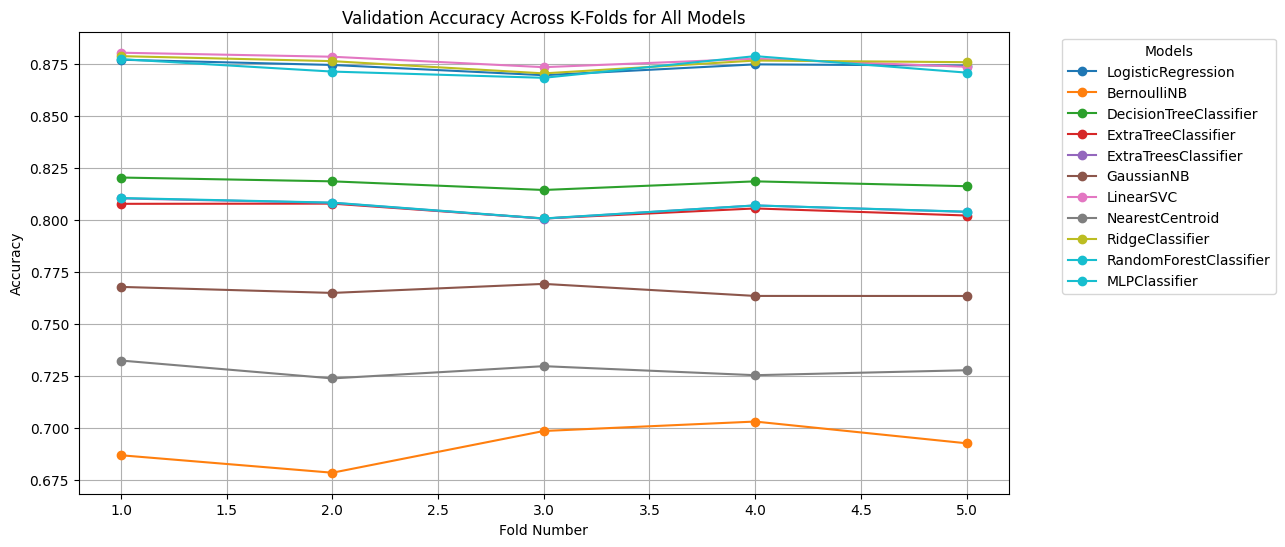

In [ ]:
# Define color map for different models
num_models = len(models_sentiment)
colors = plt.cm.tab10(np.linspace(0, 1, num_models))  # Generate unique colors

# Create a figure for Accuracy
plt.figure(figsize=(12, 6))
plt.title("Validation Accuracy Across K-Folds for All Models")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.grid(True)

# Iterate over each model and assign a unique color for Accuracy
for idx, (model_name, model) in enumerate(trained_models_sentiment.items()):
    color = colors[idx]

    # Print evaluation results
    print(f"Result of Training and evaluating {model_name}...")
    print(f'📊 {model_name} - Average Accuracy: {results_sentiment[model_name]["Accuracy"]:.3f}')
    print(f'📊 {model_name} - Average F1 Score: {results_sentiment[model_name]["F1 Score"]:.3f}')
    if results_sentiment[model_name]["ROC AUC"]:
        print(f'📊 {model_name} - Average ROC AUC: {results_sentiment[model_name]["ROC AUC"]:.3f}')
    else:
        print(f'📊 {model_name} - Average ROC AUC: N/A')

    # Plot Accuracy
    plt.plot(range(1, len(results_sentiment[model_name]["Accuracy Scores"]) + 1), 
             results_sentiment[model_name]["Accuracy Scores"], 
             label=f"{model_name}", marker='o', linestyle='-', color=color)

# Add legend and show Accuracy plot
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


📊 LogisticRegression - Average ROC AUC: 0.722
📊 BernoulliNB - Average ROC AUC: 0.718
📊 DecisionTreeClassifier - Average ROC AUC: 0.569
📊 ExtraTreeClassifier - Average ROC AUC: 0.506
📊 ExtraTreesClassifier - Average ROC AUC: 0.500
📊 GaussianNB - Average ROC AUC: 0.759
📊 LinearSVC - Average ROC AUC: N/A
📊 NearestCentroid - Average ROC AUC: N/A
📊 RidgeClassifier - Average ROC AUC: N/A
📊 RandomForestClassifier - Average ROC AUC: 0.500
📊 MLPClassifier - Average ROC AUC: 0.753


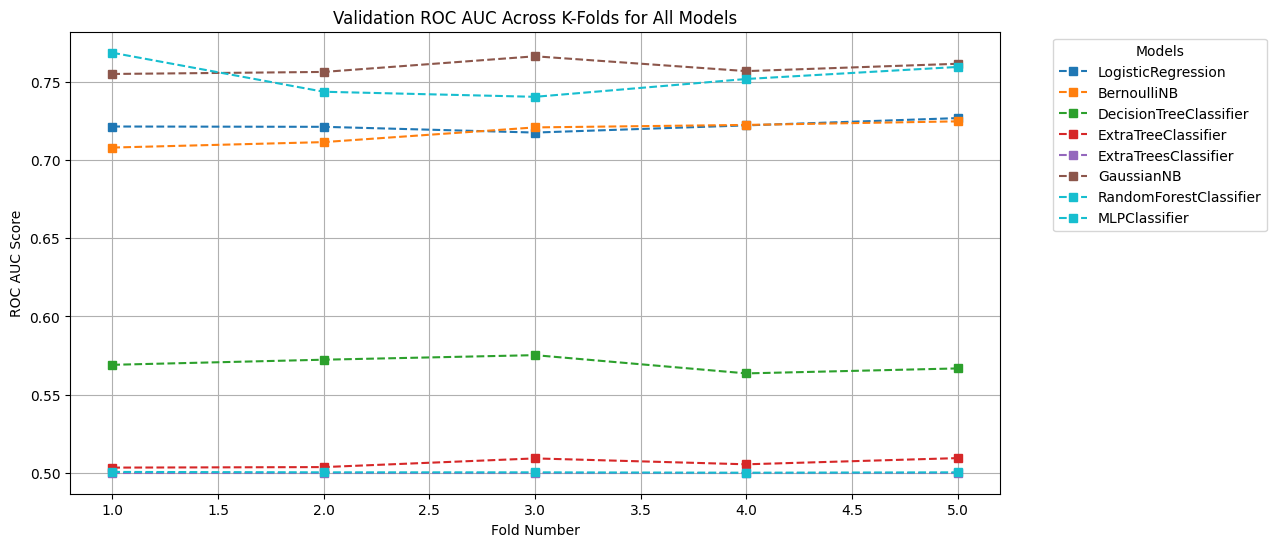

In [ ]:
# ---------------------- ROC AUC PLOT ----------------------

# Create a figure for ROC AUC
plt.figure(figsize=(12, 6))
plt.title("Validation ROC AUC Across K-Folds for All Models")
plt.xlabel("Fold Number")
plt.ylabel("ROC AUC Score")
plt.grid(True)

# Iterate over models again for ROC AUC
for idx, (model_name, model) in enumerate(trained_models_sentiment.items()):
    color = colors[idx]
    
    # Handle ROC AUC None values
    roc_auc = results_sentiment[model_name]["ROC AUC"]
    roc_auc_str = f"{roc_auc:.3f}" if roc_auc is not None else "N/A"
    print(f'📊 {model_name} - Average ROC AUC: {roc_auc_str}')
    
    # Plot ROC AUC only if it exists
    if results_sentiment[model_name]["ROC AUC Scores"]:
        plt.plot(range(1, len(results_sentiment[model_name]["ROC AUC Scores"]) + 1), 
                 results_sentiment[model_name]["ROC AUC Scores"], 
                 label=f"{model_name}", marker='s', linestyle='--', color=color)

# Add legend and show ROC AUC plot
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Print the best model
# print(f"\n🏆 Best Model: {best_model_sentiment} with Accuracy: {best_accuracy:.3f}")


In [ ]:
# ✅ Use the trained models to test on X_test_tfidf
test_results = {}

for model_name, model in trained_models_sentiment.items():
    print(f"\n🔍 Testing {model_name} on Test Data...")

    # Convert to dense format ONLY for models that require it
    if isinstance(model, (GaussianNB, MLPClassifier, NearestCentroid)):
        if issparse(X_test_sentiment_tfidf):  # Check if sparse
            X_test_sentiment_tfidf = X_test_sentiment_tfidf.toarray()

    # Scale data ONLY for distance-based models
    if isinstance(model, (RadiusNeighborsClassifier, KNeighborsClassifier)):
        scaler = StandardScaler()
        X_test_sentiment_tfidf = scaler.fit_transform(X_test_sentiment_tfidf)

    # Make Predictions
    y_test_pred = model.predict(X_test_sentiment_tfidf)

    # Compute Metrics
    test_accuracy = accuracy_score(y_test_sentiment, y_test_pred)
    test_f1 = f1_score(y_test_sentiment, y_test_pred, average='weighted')
    
    if hasattr(model, "predict_proba"):
        y_test_probs = model.predict_proba(X_test_sentiment_tfidf)
        if y_test_probs.ndim > 1:
            y_test_probs = y_test_probs.argmax(axis=1)
        test_roc_auc = roc_auc_score(y_test_sentiment, y_test_probs, multi_class='ovr')
    else:
        test_roc_auc = None  # Skip if model does not support probability prediction
    
    # Store Results
    test_results[model_name] = {
        "Test Accuracy": test_accuracy,
        "Test F1 Score": test_f1,
        "Test ROC AUC": test_roc_auc if test_roc_auc else "N/A"
    }
    
    print(f"📊 {model_name} - Test Accuracy: {test_accuracy:.3f}, Test F1 Score: {test_f1:.3f}")



🔍 Testing LogisticRegression on Test Data...
📊 LogisticRegression - Test Accuracy: 0.876, Test F1 Score: 0.863

🔍 Testing BernoulliNB on Test Data...
📊 BernoulliNB - Test Accuracy: 0.694, Test F1 Score: 0.724

🔍 Testing DecisionTreeClassifier on Test Data...
📊 DecisionTreeClassifier - Test Accuracy: 0.816, Test F1 Score: 0.769

🔍 Testing ExtraTreeClassifier on Test Data...
📊 ExtraTreeClassifier - Test Accuracy: 0.801, Test F1 Score: 0.725

🔍 Testing ExtraTreesClassifier on Test Data...
📊 ExtraTreesClassifier - Test Accuracy: 0.803, Test F1 Score: 0.715

🔍 Testing GaussianNB on Test Data...
📊 GaussianNB - Test Accuracy: 0.774, Test F1 Score: 0.792

🔍 Testing LinearSVC on Test Data...
📊 LinearSVC - Test Accuracy: 0.874, Test F1 Score: 0.867

🔍 Testing NearestCentroid on Test Data...
📊 NearestCentroid - Test Accuracy: 0.734, Test F1 Score: 0.757

🔍 Testing RidgeClassifier on Test Data...
📊 RidgeClassifier - Test Accuracy: 0.877, Test F1 Score: 0.866

🔍 Testing RandomForestClassifier on T